In [1]:
import os
import sys
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import ydata_profiling
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
from IPython.display import Audio, display

plt.style.use('seaborn-v0_8-paper')
sns.set_context("notebook", font_scale=1.2)

current_dir = Path.cwd()
DATASET_ROOT = current_dir.parent.parent / "data" / "noise_dataset" / "RIR"

if not DATASET_ROOT.exists():
    DATASET_ROOT = Path("data/noise_dataset/RIR")

print(f"RIR Dataset Path: {DATASET_ROOT.resolve()}")
SAMPLE_RATE = 16000

CATEGORY_MAP = {
    "pointsource_noises": "pointsource",
    "real_rirs_isotropic_noises": "isotropic",
    "simulated_rirs": "simulated"
}

RIR Dataset Path: C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOOF\data\noise_dataset\RIR


In [2]:
def build_rir_inventory(root_path: Path, category_map: Dict[str, str]) -> pd.DataFrame:
    """
    Scans the RIR dataset and builds a Master DataFrame with normalized category names.
    Handles specific subcategory logic: 'simulated' has rooms, others default to 'NA'.

    Args:
        root_path (Path): Path object pointing to the RIR root directory.
        category_map (Dict): Dictionary mapping original folder names to clean names.

    Returns:
        pd.DataFrame: Structured metadata including Category, Subcategory, and Room Info.
    """
    if not root_path.exists():
        raise FileNotFoundError(f"Root path not found: {root_path}")

    wav_files = list(root_path.rglob("*.wav"))
    inventory_data = []

    print(f"Processing {len(wav_files)} RIR files...")

    for file_path in wav_files:
        try:
            relative_parts = file_path.relative_to(root_path).parts
            
            original_folder = relative_parts[0]
            clean_category = category_map.get(original_folder, original_folder)
            
            # Logic for Subcategories
            if clean_category == "simulated":
                # Expecting: simulated_rirs / large_room / ...
                if len(relative_parts) >= 2:
                    subcategory = relative_parts[1] 
                else:
                    subcategory = "unknown"
            else:
                # For pointsource and isotropic, we set subcategory to NA 
                # unless there is a specific subfolder structure we want to preserve
                subcategory = "NA"

            # Quick duration check (header only)
            duration = librosa.get_duration(path=file_path)

            inventory_data.append({
                "Filename": file_path.name,
                "Category": clean_category,
                "Subcategory": subcategory,
                "Original_Folder": original_folder,
                "Duration": float(f"{duration:.4f}"),
                "Format": file_path.suffix.replace('.', ''),
                "Path": str(file_path.resolve())
            })
            
        except Exception:
            continue

    df = pd.DataFrame(inventory_data)
    
    # Reorder columns
    df = df[["Category", "Subcategory", "Filename", "Duration", "Format", "Path"]]
    
    return df

df_rir_master = build_rir_inventory(DATASET_ROOT, CATEGORY_MAP)

print(f"\nDataset Shape: {df_rir_master.shape}")
display(df_rir_master.head())
display(df_rir_master["Category"].value_counts())
display(df_rir_master.groupby(["Category", "Subcategory"]).size())

Processing 61260 RIR files...

Dataset Shape: (61260, 6)


,Category,Subcategory,Filename,Duration,Format,Path
0,pointsource,NA,noise-free-sound-0000.wav,17.6588,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
1,pointsource,NA,noise-free-sound-0001.wav,40.5365,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
2,pointsource,NA,noise-free-sound-0002.wav,71.2175,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
3,pointsource,NA,noise-free-sound-0003.wav,14.2358,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
4,pointsource,NA,noise-free-sound-0004.wav,2.9865,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...


Category
simulated      60000
pointsource      843
isotropic        417
Name: count, dtype: int64

Category     Subcategory
isotropic    NA               417
pointsource  NA               843
simulated    largeroom      20000
             mediumroom     20000
             smallroom      20000
dtype: int64

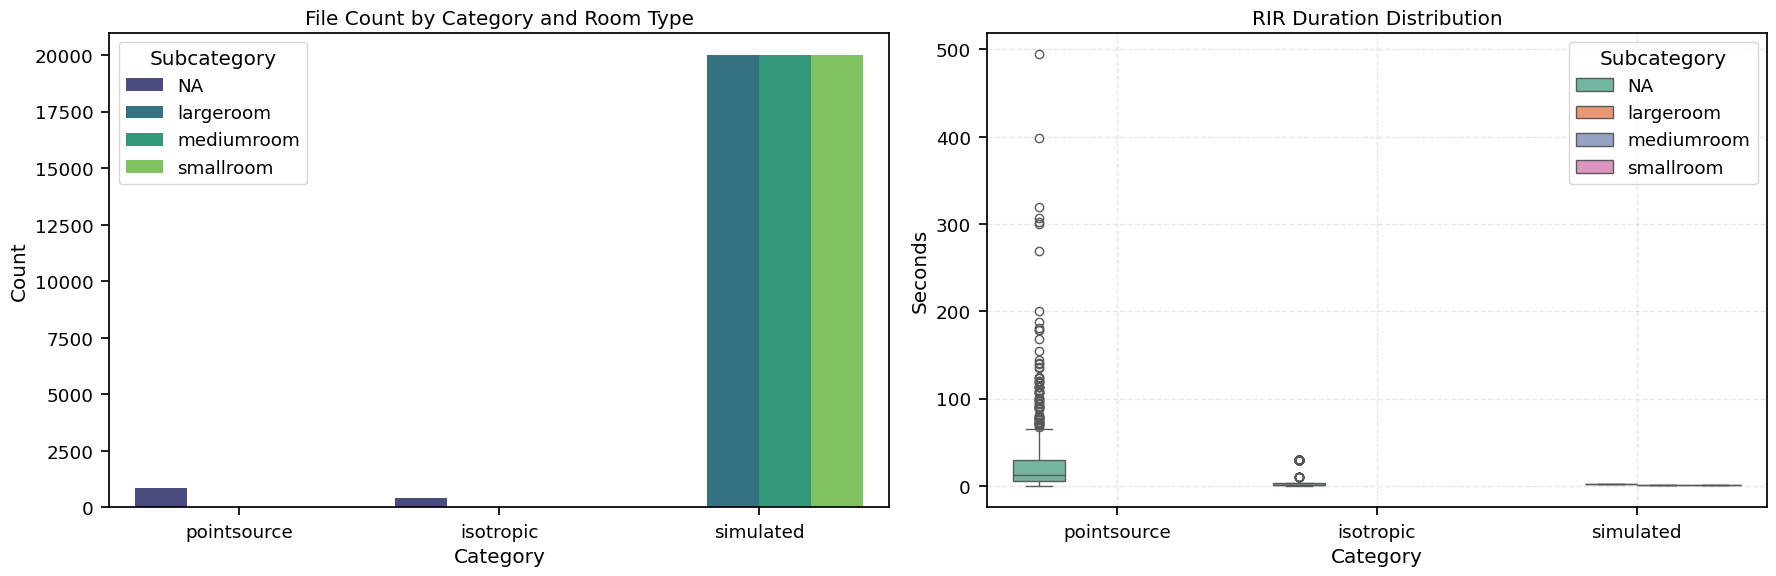

Min       Max     Mean  Count
Category    Subcategory                                  
isotropic   NA           0.1042   30.0000   7.7097    417
pointsource NA           0.0261  494.6599  25.2469    843
simulated   largeroom    2.0000    2.0000   2.0000  20000
            mediumroom   1.0000    1.0000   1.0000  20000
            smallroom    0.5000    0.5000   0.5000  20000

In [3]:
def analyze_rir_statistics(df: pd.DataFrame):
    """
    Visualizes the count and duration distribution of the RIR dataset.
    RIRs are typically very short (impulses), so we use specific scales.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # 1. Count Plot
    sns.countplot(data=df, x="Category", hue="Subcategory", palette="viridis", ax=ax1)
    ax1.set_title("File Count by Category and Room Type")
    ax1.set_ylabel("Count")
    
    # 2. Duration Boxplot
    sns.boxplot(data=df, x="Category", y="Duration", hue="Subcategory", palette="Set2", ax=ax2)
    ax2.set_title("RIR Duration Distribution")
    ax2.set_ylabel("Seconds")
    ax2.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Numeric Summary
    stats = df.groupby(["Category", "Subcategory"])["Duration"].agg(
        Min='min', Max='max', Mean='mean', Count='count'
    ).round(4)
    
    return stats

rir_stats = analyze_rir_statistics(df_rir_master)
display(rir_stats)

In [ ]:
def plot_energy_decay_curve(df: pd.DataFrame, n_samples: int = 1):
    """
    Plots the Waveform and the Energy Decay Curve (EDC) for sampled RIRs.
    The EDC visualizes how sound energy dissipates in the room (Reverberation).
    
    Args:
        df (pd.DataFrame): Master DataFrame.
        n_samples (int): Samples per subcategory to visualize.
    """
    # Filter only 'simulated' category for clear room comparison
    simulated_df = df[df['Category'] == 'simulated']
    subcategories = simulated_df['Subcategory'].unique()
    
    if len(subcategories) == 0:
        print("No simulated RIRs found for analysis.")
        return

    plt.figure(figsize=(15, 5 * len(subcategories)))
    
    for i, room_type in enumerate(subcategories):
        subset = simulated_df[simulated_df['Subcategory'] == room_type]
        if subset.empty: continue
            
        sample = subset.sample(1).iloc[0]
        y, sr = librosa.load(sample['Path'], sr=SAMPLE_RATE)
        
        # 1. Waveform
        plt.subplot(len(subcategories), 2, 2*i + 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.7)
        plt.title(f"Impulse Response: {room_type} ({sample['Filename']})")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        
        # 2. Energy Decay Curve (Schroeder Integration approximation)
        plt.subplot(len(subcategories), 2, 2*i + 2)
        
        # Calculate energy (squared amplitude)
        energy = y ** 2
        # Reverse integration (Schroeder)
        edc = np.cumsum(energy[::-1])[::-1]
        # Convert to dB
        edc_db = 10 * np.log10(edc + 1e-10)
        # Normalize to 0 dB at max
        edc_db = edc_db - np.max(edc_db)
        
        times = np.linspace(0, len(y)/sr, len(y))
        
        plt.plot(times, edc_db, color='#C44E52', linewidth=2)
        plt.title(f"Energy Decay Curve (Log): {room_type}")
        plt.xlabel("Time (s)")
        plt.ylabel("Energy (dB)")
        plt.ylim(-60, 5) # Visualize up to -60dB (RT60 standard)
        plt.grid(True, which="both", ls="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_energy_decay_curve(df_rir_master)

In [4]:
ydata_profiling.ProfileReport(df_rir_master, title="MUSAN Dataset Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]